In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [142]:
#Read the datafile
seqlearn_table = pd.read_csv("10_subject_data.csv")

In [143]:
# Remove white spaces in the column names and make them into strings
seqlearn_table.columns = seqlearn_table.columns.str.replace(' ', '_')

In [144]:
#selecting relevant columns
df = seqlearn_table.loc[:, ["phase_id", "mascot_name", "video_context", "Response", 'stim_type']]

#dropping all columns except recog_random and recog_ordered
data_recog = df[(df.phase_id == "recog_random") | (df.phase_id == "recog_ordered")]

# Dropping NaN values
clean_data_recog = data_recog.dropna()

clean_data_recog

,phase_id,mascot_name,video_context,Response,stim_type
186,recog_random,Kounudoun,performance,sure old,studied
188,recog_random,Jarbo,alley,sure old,studied
192,recog_random,Kapal,hallway,sure new,lure
194,recog_random,Kounudoun,street-fair-1,sure new,lure
197,recog_random,Fukaya,outside-building,sure old,studied
...,...,...,...,...,...
9374,recog_random,Kounudoun,outside-store,sure old,studied
9377,recog_random,Fukaya,standing-behind-cake,sure old,studied
9380,recog_random,Kounudoun,park-with-audience,sure old,studied
9383,recog_random,Jarbo,roof,maybe old,studied


In [145]:
# look at the number of different kinds of responses across participants
test = clean_data_recog.groupby(['video_context', 'stim_type'])['Response'].value_counts()
test.head(20)

video_context  stim_type  Response 
3/1/01         lure       guess new    1
                          sure old     1
               studied    maybe old    2
                          guess new    1
                          guess old    1
                          maybe new    1
                          sure new     1
3/2/01         lure       sure new     3
                          guess new    2
                          guess old    2
               studied    maybe old    1
CPR            lure       sure new     7
                          maybe old    2
               studied    sure old     3
                          maybe old    2
                          guess old    1
alley          lure       maybe new    2
                          sure new     1
               studied    maybe old    2
                          sure old     2
Name: Response, dtype: int64

In [147]:
# When stim_type = studied and response is sure/maybe/guess old, add value 'hit' in the same row in a new column

recog_test_data = pd.DataFrame(clean_data_recog, columns = ['Response', 'stim_type', 'video_context', 'response_type'])
recog_test_data['response_type'] = np.where((recog_test_data['stim_type'] == 'studied') & ((recog_test_data['Response'] == 'sure old') | (recog_test_data['Response'] == 'maybe old') | (recog_test_data['Response'] == 'guess old')), True, False)

# Add hits to the new column
recog_test_data['response_type'] = recog_test_data['response_type'].replace(True, 'Hit')
recog_test_data['response_type'] = recog_test_data['response_type'].replace(False, 'Miss/FA/CR')
recog_test_data

,Response,stim_type,video_context,response_type
186,sure old,studied,performance,Hit
188,sure old,studied,alley,Hit
192,sure new,lure,hallway,Miss/FA/CR
194,sure new,lure,street-fair-1,Miss/FA/CR
197,sure old,studied,outside-building,Hit
...,...,...,...,...
9374,sure old,studied,outside-store,Hit
9377,sure old,studied,standing-behind-cake,Hit
9380,sure old,studied,park-with-audience,Hit
9383,maybe old,studied,roof,Hit


In [149]:
# total number of Hit vs. Other responses per video 
hit_vals = recog_test_data.groupby(['video_context'])['response_type'].value_counts()
print(hit_vals)
# total number of responses per video 
print(clean_data_recog['video_context'].value_counts())

video_context  response_type
3/1/01         Miss/FA/CR       5
               Hit              3
3/2/01         Miss/FA/CR       7
               Hit              1
CPR            Miss/FA/CR       9
                               ..
workout        Hit              1
zoo-1          Miss/FA/CR       4
               Hit              2
zoo-2          Miss/FA/CR       7
               Hit              2
Name: response_type, Length: 376, dtype: int64
exercise-class            80
beach                     35
announcers                35
park                      34
dance-with-large-group    31
                          ..
walking-in-street          3
town                       3
farm                       3
pig-pen                    3
spinning-soccer-ball       2
Name: video_context, Length: 194, dtype: int64


In [150]:
# can we find a way to put both of these values into a dataframe so that we can calculate hit rate?

hit = pd.DataFrame(recog_test_data.groupby(['video_context'])['response_type'].value_counts(), columns = ['response_type', 'resp_type_total'])
hit['resp_type_total'] = hit.groupby('video_context')['response_type'].transform('sum')
hit = hit.rename(columns={'response_type' : 'response_count'})
#fix formatting 
hit = hit.reset_index(0)
hit = hit.reset_index(0)
organized_data = hit.reindex(columns= ['video_context', 'response_type', 'response_count','resp_type_total'])
# drop Miss/FA/CR response counts
clean_HR_data = organized_data[(organized_data.response_type == "Hit")]
clean_HR_data
#final table!
HR_per_mas_data = pd.DataFrame(clean_HR_data, columns = ['video_context', 'Hit_Rate'])
HR_per_mas_data['Hit_Rate'] = clean_HR_data['response_count'] / clean_HR_data['resp_type_total']
HR_per_mas_data.set_index('video_context')

,Hit_Rate
video_context,
3/1/01,0.375000
3/2/01,0.125000
CPR,0.400000
alley,0.500000
ammusement-ride-1,0.250000
...,...
with-tourist-kids,0.600000
with-wood,0.444444
workout,0.200000


Text(0.5, 1.0, 'Mascot Video Memorability')

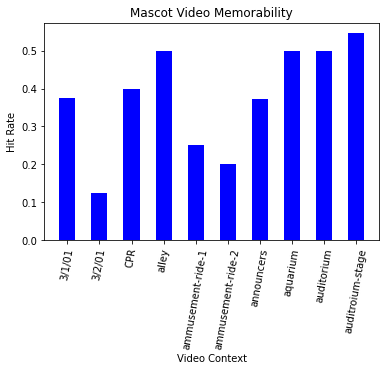

In [151]:
#plotting HR vs. Video
plt.bar(HR_per_mas_data['video_context'].head(10), HR_per_mas_data['Hit_Rate'].head(10), color ='blue',
        width = 0.5)
# rotate the tick labels for the x axis
x = plt.gca().xaxis
for item in x.get_ticklabels():
    item.set_rotation(80)
# add a label to the x axis
plt.xlabel('Video Context')
# add a label to the y axis
plt.ylabel('Hit Rate')
# add a title
plt.title('Mascot Video Memorability')

## Next Steps:
* memorability per mascot
* graph average HR/ mascot 
* Linear Mixed Model 